# Prediction and hypothesis testing on a cycling dataset

In this project I'll try to answer several questions:

- What variables affect caloric expenditure the most when I'm cycling?
- Can this caloric expenditure be accurately predicted for any given route?
- Are races and normal rides significantly different data-wise? In which ways?
    
To answer them I'll be using a dataset of my cycling rides from 2016 up to this day, courtesy of **SportTracks**'s elegantly simple data export options.

## 1. Data wrangling

The goal of this step is simple: taking our raw data intake and transforming it into a format and layout that can easily be used to extract conclusions and insights. This will mainly be achieved via *Pandas*.

In [1]:
#Instead of having multiple library imports through the project I prefer to contain them all in a single cell, to both
#prevent double imports as well as improving the visual aspect of this notebook. Some notebook-wide settings are also
#housed in this cell.


import pandas as pd
import numpy as np
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import statsmodels.api as sm
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
import plotly.express as px
from pylab import rcParams 
from ipywidgets import interact
import matplotlib.image as mpimg

warnings.simplefilter(action='ignore', category=FutureWarning) #Getting rid of warnings.
rcParams["figure.figsize"] = [12, 8] #Our favourite figure size (or aspect ratio...it's really both).
cf.go_offline()
pd.options.plotting.backend='plotly' #I find Plotly to be a better plotting tool, so I'm setting it as default.

As I mentioned our data comes from **SportTracks**, a training tracking website that lets you download all your activities in a neat csv, filtered by sport and containing the most useful data fields.

Here's what the activity feed looks like:

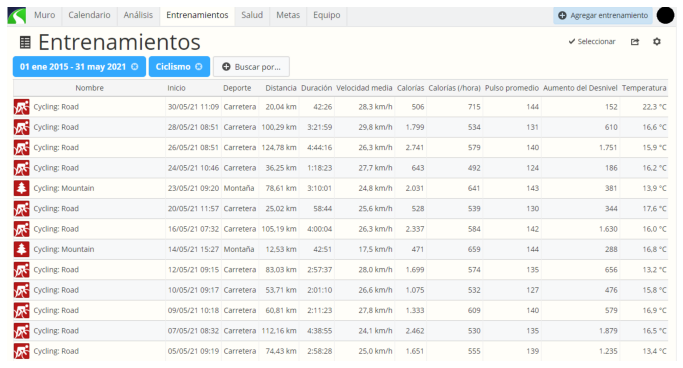

In [2]:
img=mpimg.imread('sporttracks.png')
plt.imshow(img) 
plt.grid(None) #Removing the image grid.
plt.axis('off') #Removing the numeric axis.
plt.show() #Displaying the figure.

Since our data export is in csv format, we'll begin our data exploration by loading it into a dataframe object.

In [3]:
df = pd.read_csv('workouts.csv', encoding='utf-8')

In [4]:
df.head()

,Nombre,Inicio,Deporte,Distancia,Duración,Velocidad media,Calorías,Calorías (/hora),Pulso promedio,Aumento del Desnivel,Temperatura
0,Cycling: Road,2021-05-30 11:09:26,Carretera,"20,04 km",42:26:00,"28,3 km/h",506.0,715.0,144.0,152,"22,3"
1,Cycling: Road,2021-05-28 8:51:04,Carretera,"100,29 km",3:21:59,"29,8 km/h",1799.0,534.0,131.0,610,"16,6"
2,Cycling: Road,2021-05-26 8:51:07,Carretera,"124,78 km",4:44:16,"26,3 km/h",2741.0,579.0,140.0,1751,"15,9"
3,Cycling: Road,2021-05-24 10:46:51,Carretera,"36,25 km",1:18:23,"27,7 km/h",643.0,492.0,124.0,186,"16,2"
4,Cycling: Mountain,2021-05-23 9:20:16,Montaña,"78,61 km",3:10:01,"24,8 km/h",2031.0,641.0,143.0,381,"13,9"


In [5]:
#Let's check for missing values. Since very few activities have missing data we can safely drop them.

df.isnull().sum()

Nombre                  0
Inicio                  0
Deporte                 0
Distancia               0
Duración                0
Velocidad media         4
Calorías                4
Calorías (/hora)        4
Pulso promedio          8
Aumento del Desnivel    0
Temperatura             3
dtype: int64

In [6]:
#Dropping the rows with missing data.

df.dropna(axis=0, how='any', inplace=True)

In [7]:
#To clean up our dataframe and prevent any future naming issues, let's rename the columns.

df.rename(columns={'Nombre':'name',
                      'Inicio':'start',
                      'Deporte': 'sport',
                      'Distancia':'distance',
                      'Duración':'duration',
                      'Velocidad media':'avg_speed',
                      'Calorías':'calories',
                      'Calorías (/hora)':'cals_per_hour',
                      'Pulso promedio':'heartrate',
                      'Aumento del Desnivel':'climb',
                      'Temperatura':'temp'}, inplace=True)

In [8]:
df.head()

,name,start,sport,distance,duration,avg_speed,calories,cals_per_hour,heartrate,climb,temp
0,Cycling: Road,2021-05-30 11:09:26,Carretera,"20,04 km",42:26:00,"28,3 km/h",506.0,715.0,144.0,152,"22,3"
1,Cycling: Road,2021-05-28 8:51:04,Carretera,"100,29 km",3:21:59,"29,8 km/h",1799.0,534.0,131.0,610,"16,6"
2,Cycling: Road,2021-05-26 8:51:07,Carretera,"124,78 km",4:44:16,"26,3 km/h",2741.0,579.0,140.0,1751,"15,9"
3,Cycling: Road,2021-05-24 10:46:51,Carretera,"36,25 km",1:18:23,"27,7 km/h",643.0,492.0,124.0,186,"16,2"
4,Cycling: Mountain,2021-05-23 9:20:16,Montaña,"78,61 km",3:10:01,"24,8 km/h",2031.0,641.0,143.0,381,"13,9"


In [9]:
#The 'name column' doesn't give us any meaningful information so we'll drop it.

df.drop('name',axis=1, inplace=True)

In [10]:
#We can also drop 'cals_per hour' since it's a combination of two existing columns.

df.drop('cals_per_hour',axis=1, inplace=True)

In [11]:
#Some of our columns need to be typecasted into more useful formats. Let's get to it.

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 813
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   start      800 non-null    object 
 1   sport      800 non-null    object 
 2   distance   800 non-null    object 
 3   duration   800 non-null    object 
 4   avg_speed  800 non-null    object 
 5   calories   800 non-null    float64
 6   heartrate  800 non-null    float64
 7   climb      800 non-null    int64  
 8   temp       800 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 62.5+ KB


In [12]:
#Converting 'start' to datetime format. Using the correct formal is crucial at this point.

df['start'] = pd.to_datetime(df['start'], format='%Y-%m-%d %H:%M:%S')

In [13]:
#The column Dtype has been changed successfully.

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 813
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   start      800 non-null    datetime64[ns]
 1   sport      800 non-null    object        
 2   distance   800 non-null    object        
 3   duration   800 non-null    object        
 4   avg_speed  800 non-null    object        
 5   calories   800 non-null    float64       
 6   heartrate  800 non-null    float64       
 7   climb      800 non-null    int64         
 8   temp       800 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 62.5+ KB


In [14]:
#'Sport' is a categorical variable. Let's see the values it can have.

df['sport'].value_counts()

Carretera     538
Montaña       129
Ciclismo       69
Virtual        59
Interiores      4
Entrenador      1
Name: sport, dtype: int64

In [15]:
#Those 6 categories can be summed up into just 3 (road, mountain, indoor).

df['sport'].replace('Carretera','road',inplace=True)
df['sport'].replace('Montaña','mountain',inplace=True)
df['sport'].replace('Ciclismo','road',inplace=True)
df['sport'].replace('Virtual','indoor',inplace=True)
df['sport'].replace('Interiores','indoor',inplace=True)
df['sport'].replace('Entrenador','indoor',inplace=True)

In [16]:
#Let's check if the string replace has worked successfully.

df['sport'].value_counts()

road        607
mountain    129
indoor       64
Name: sport, dtype: int64

In [17]:
#To convert 'distance' into a float we'll simply use string replace.

df['distance'] = df['distance'].str.replace(' km','')
df['distance'] = df['distance'].str.replace(',','.') #Replacing dots with commas.
df['distance'] = df['distance'].astype(float) #Finally typecasting as float.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 813
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   start      800 non-null    datetime64[ns]
 1   sport      800 non-null    object        
 2   distance   800 non-null    float64       
 3   duration   800 non-null    object        
 4   avg_speed  800 non-null    object        
 5   calories   800 non-null    float64       
 6   heartrate  800 non-null    float64       
 7   climb      800 non-null    int64         
 8   temp       800 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 62.5+ KB


In [19]:
df.head()

,start,sport,distance,duration,avg_speed,calories,heartrate,climb,temp
0,2021-05-30 11:09:26,road,20.04,42:26:00,"28,3 km/h",506.0,144.0,152,"22,3"
1,2021-05-28 08:51:04,road,100.29,3:21:59,"29,8 km/h",1799.0,131.0,610,"16,6"
2,2021-05-26 08:51:07,road,124.78,4:44:16,"26,3 km/h",2741.0,140.0,1751,"15,9"
3,2021-05-24 10:46:51,road,36.25,1:18:23,"27,7 km/h",643.0,124.0,186,"16,2"
4,2021-05-23 09:20:16,mountain,78.61,3:10:01,"24,8 km/h",2031.0,143.0,381,"13,9"


In [20]:
#This function will get rid of surplus characters.

def time_add(x):
    if len(x) == 8:
        return '00:' + x[:5]
    elif len(x) == 7:
        return '0' + x
    elif len(x) == 4:
        return '00:0' + x
    elif len(x) == 5:
        return '00:' + x
    else:
        return x

In [21]:
#Applying the function.

df['duration'] = df['duration'].apply(time_add)

In [22]:
#Now we can finally convert it to a TimeDelta object.

df['duration'] = pd.to_timedelta(df['duration'])

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 813
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   start      800 non-null    datetime64[ns] 
 1   sport      800 non-null    object         
 2   distance   800 non-null    float64        
 3   duration   800 non-null    timedelta64[ns]
 4   avg_speed  800 non-null    object         
 5   calories   800 non-null    float64        
 6   heartrate  800 non-null    float64        
 7   climb      800 non-null    int64          
 8   temp       800 non-null    object         
dtypes: datetime64[ns](1), float64(3), int64(1), object(3), timedelta64[ns](1)
memory usage: 62.5+ KB


In [24]:
#To perform a detailed analysis it would be better to have the duration in minutes (int). Let's do it.

df['duration'] = df['duration'].dt.total_seconds().div(60).astype(int)

In [25]:
df.head()

,start,sport,distance,duration,avg_speed,calories,heartrate,climb,temp
0,2021-05-30 11:09:26,road,20.04,42,"28,3 km/h",506.0,144.0,152,"22,3"
1,2021-05-28 08:51:04,road,100.29,201,"29,8 km/h",1799.0,131.0,610,"16,6"
2,2021-05-26 08:51:07,road,124.78,284,"26,3 km/h",2741.0,140.0,1751,"15,9"
3,2021-05-24 10:46:51,road,36.25,78,"27,7 km/h",643.0,124.0,186,"16,2"
4,2021-05-23 09:20:16,mountain,78.61,190,"24,8 km/h",2031.0,143.0,381,"13,9"


In [26]:
#The last column that we need to work on is 'avg_speed'. Let's convert it to a float.

df['avg_speed'] = df['avg_speed'].str.replace(' km/h','') #Deleting 'km/h' and the preceding space.
df['avg_speed'] = df['avg_speed'].str.replace(',','.') #Changing commas for dots.
df['avg_speed'] = df['avg_speed'].astype(float) #Finally typecasting as a float.

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 813
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   start      800 non-null    datetime64[ns]
 1   sport      800 non-null    object        
 2   distance   800 non-null    float64       
 3   duration   800 non-null    int32         
 4   avg_speed  800 non-null    float64       
 5   calories   800 non-null    float64       
 6   heartrate  800 non-null    float64       
 7   climb      800 non-null    int64         
 8   temp       800 non-null    object        
dtypes: datetime64[ns](1), float64(4), int32(1), int64(1), object(2)
memory usage: 59.4+ KB


In [27]:
#Typecasting 'temp'.

df['temp'] = df['temp'].astype(str)
df['temp'] = df['temp'].str.replace(',','.')
df['temp'] = df['temp'].astype(float)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 813
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   start      800 non-null    datetime64[ns]
 1   sport      800 non-null    object        
 2   distance   800 non-null    float64       
 3   duration   800 non-null    int32         
 4   avg_speed  800 non-null    float64       
 5   calories   800 non-null    float64       
 6   heartrate  800 non-null    float64       
 7   climb      800 non-null    int64         
 8   temp       800 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int32(1), int64(1), object(1)
memory usage: 59.4+ KB


In [29]:
df.head()

,start,sport,distance,duration,avg_speed,calories,heartrate,climb,temp
0,2021-05-30 11:09:26,road,20.04,42,28.3,506.0,144.0,152,22.3
1,2021-05-28 08:51:04,road,100.29,201,29.8,1799.0,131.0,610,16.6
2,2021-05-26 08:51:07,road,124.78,284,26.3,2741.0,140.0,1751,15.9
3,2021-05-24 10:46:51,road,36.25,78,27.7,643.0,124.0,186,16.2
4,2021-05-23 09:20:16,mountain,78.61,190,24.8,2031.0,143.0,381,13.9


## 2. Data exploration

Now that all our columns are nice and tidy we can finally take a good look at our data.
Let's begin by displaying a general overview of our variables.

In [30]:
df.describe()

,distance,duration,avg_speed,calories,heartrate,climb,temp
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,45.076225,109.228750,24.776125,1005.875000,133.875000,455.420000,17.439125
std,26.918241,62.432112,4.127325,584.823373,7.815416,392.482987,6.484857
min,0.080000,0.000000,8.100000,2.000000,96.000000,0.000000,-0.500000
25%,24.930000,63.000000,22.700000,592.500000,129.000000,194.000000,12.600000
50%,40.525000,99.500000,25.400000,904.500000,134.000000,335.500000,16.500000
75%,58.065000,140.000000,27.000000,1274.250000,139.000000,591.500000,22.100000
max,204.640000,450.000000,37.700000,4295.000000,160.000000,2602.000000,35.500000


In [31]:
#Correlation.

df.corr()

,distance,duration,avg_speed,calories,heartrate,climb,temp
distance,1.000000,0.961330,0.171813,0.940221,0.293689,0.738512,-0.111073
duration,0.961330,1.000000,-0.053964,0.970008,0.277465,0.820625,-0.122798
avg_speed,0.171813,-0.053964,1.000000,-0.023561,0.085935,-0.146379,0.153999
calories,0.940221,0.970008,-0.023561,1.000000,0.428322,0.840935,-0.111749
heartrate,0.293689,0.277465,0.085935,0.428322,1.000000,0.368204,-0.023022
climb,0.738512,0.820625,-0.146379,0.840935,0.368204,1.000000,-0.014906
temp,-0.111073,-0.122798,0.153999,-0.111749,-0.023022,-0.014906,1.000000


<AxesSubplot:>

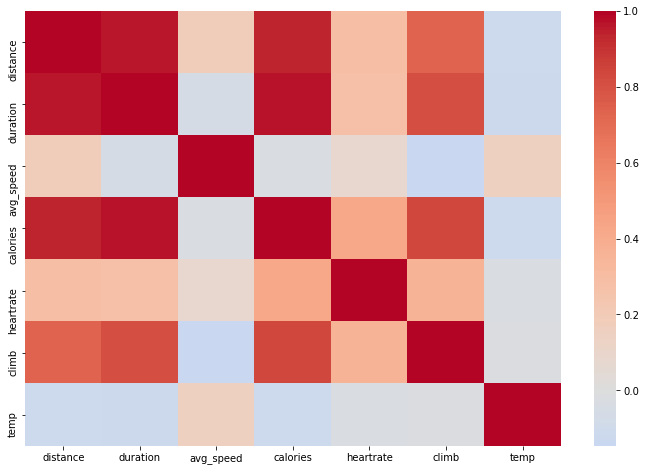

In [32]:
#Displaying the correlation matrix as a heatmap using Seaborn. Distance and duration's correlations with calories are evident.

sns.heatmap(df.corr(), center=0, cmap='coolwarm')

We can see that both **duration** and **distance** seem to be good predictors for caloric expenditure, with **climb** in a third place. They will be further explored in the following section.

## 3. Data visualization

Since *calories* is our target variable, let's explore the way it's distributed.
Using a simple interactive histogram we can appreciate how the distribution has a long tail on the right and almost none on the left.

In [33]:
#Histogram using Plotly.

df['calories'].hist(title="Calories per ride")

Let's use a bar plot to visualize how many activities are in each sport category.

In [34]:
px.bar(df.sport.value_counts())

Let's now explore the relationships between the different variables. We already know that there's a strong correlation between *distance/duration/climb* and *calories* burned, but we might gain new insights after seeing all variables paired up.

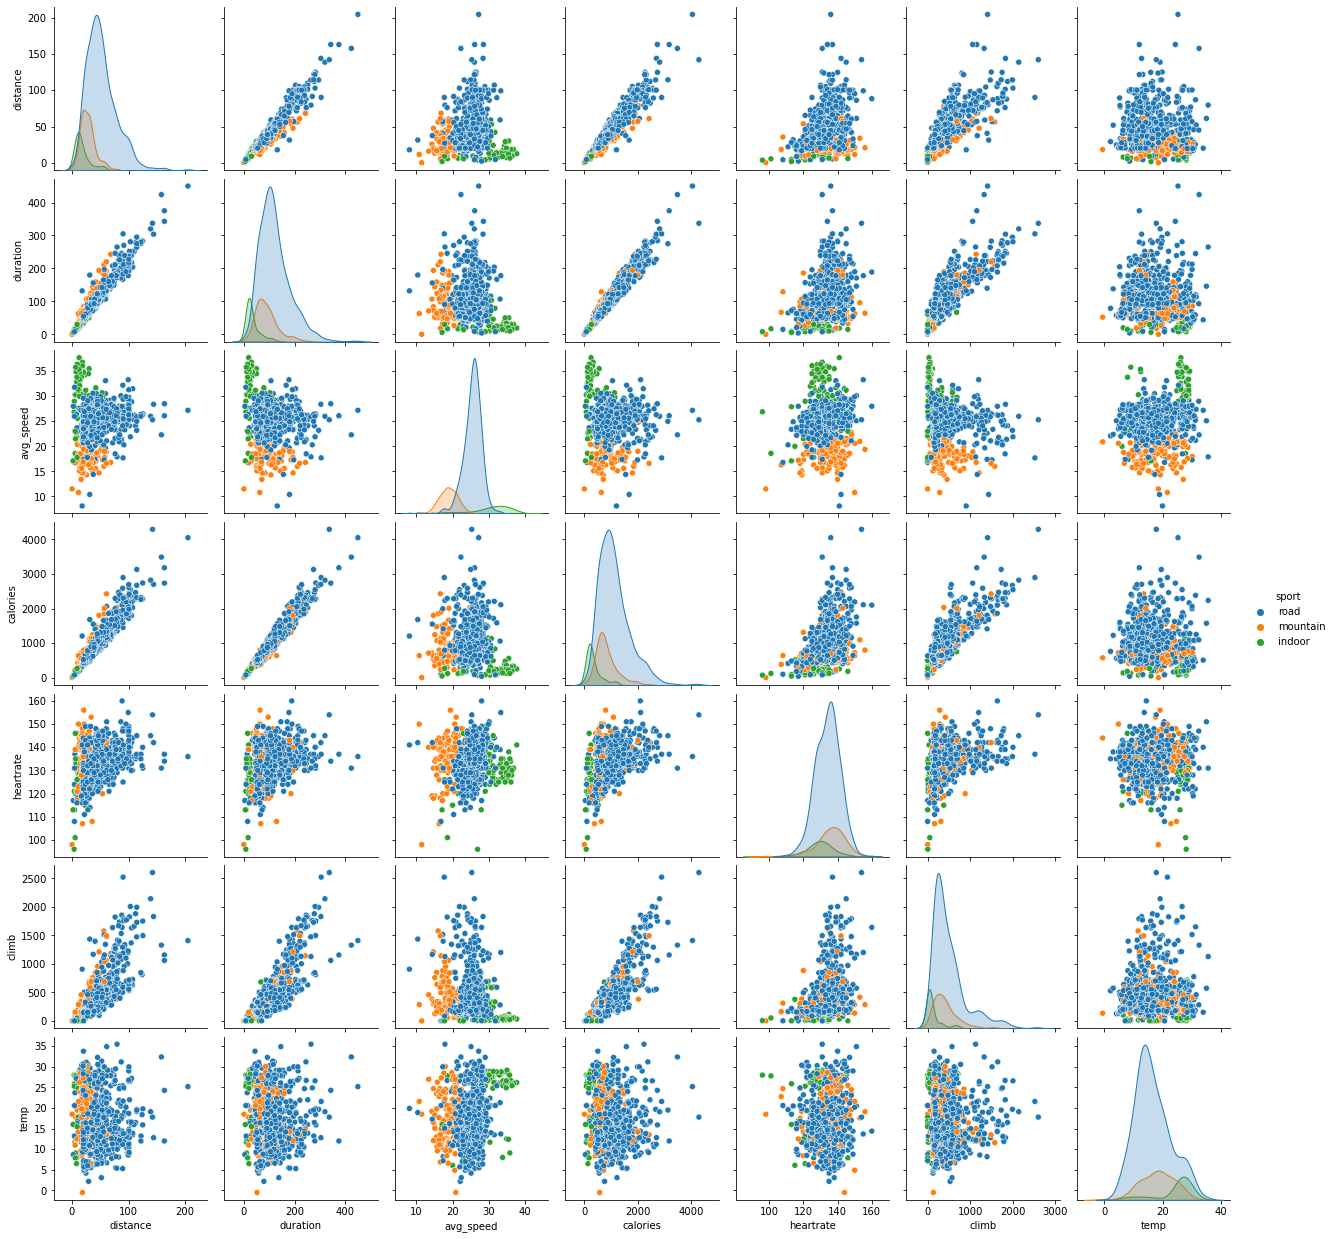

In [35]:
#Pair plot using Seaborn.

sns.pairplot(data=df, hue = 'sport')

It's easy to see that most activities were road bike rides, as were the longest and hardest. Note how the variance in indoor rides is much smaller than for the other sports.

Let's explore the relationship between *duration, distance, climb* and our target variable (*calories*). Displaying a regression plot for every variable will allow us to better understand which one could be the best predictor and why.

As the chart below shows, *duration* seems to be the best predictor since it has few outliers and a variance that's far lower than that of the other predictor variables. The confidence interval seems to be quite tight.

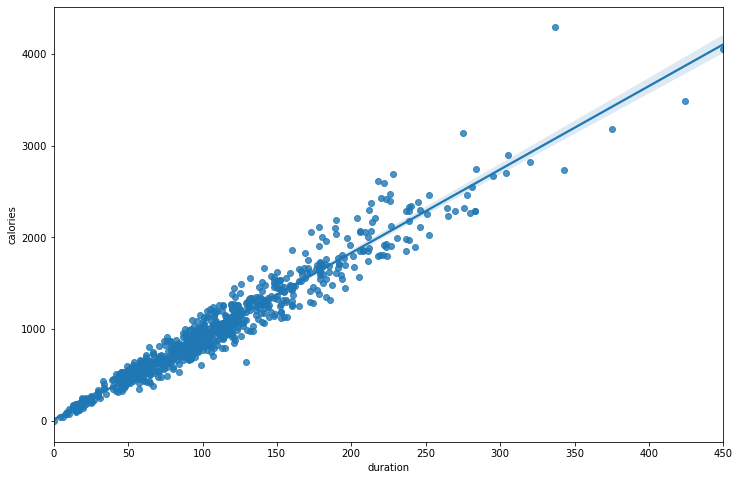

In [36]:
_ = sns.regplot(data=df, x='duration', y='calories')

*Distance* is also a good predictor, but the variance is higher than it was for *duration*. There is also a marked increment of the **heteroscedasticity**.

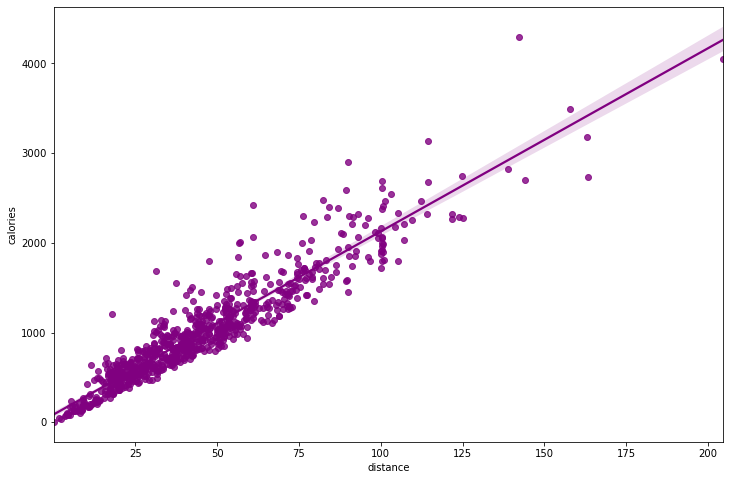

In [37]:
_ = sns.regplot(data=df, x='distance', y='calories', color='purple')

*Climb* could be a decent enough predictor, but the high variance and the presence of many outliers severely restrict its usefulness when we compare it with the previous variables. I won't be using it for my prediction for this very reason.

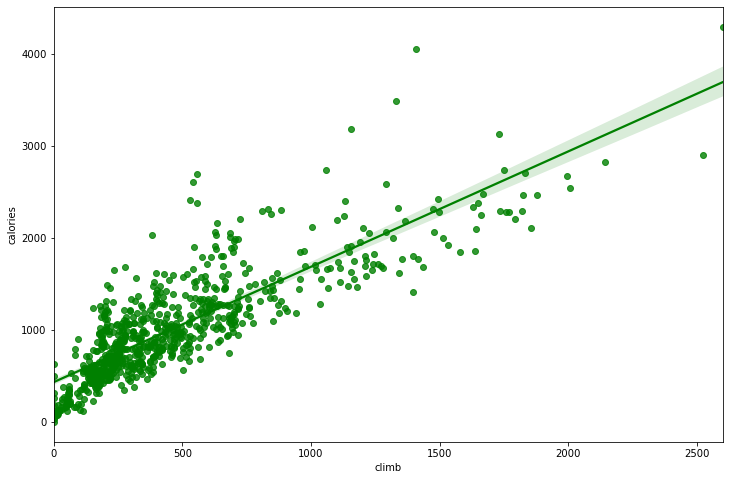

In [38]:
_ = sns.regplot(data=df, x='climb', y='calories', color='green')

As this chart shows, the correlation between *duration* and *calories* is quite constant regardless of sport. It's interesting to note how indoor rides have the least variance, since they are performed in a controlled environment.

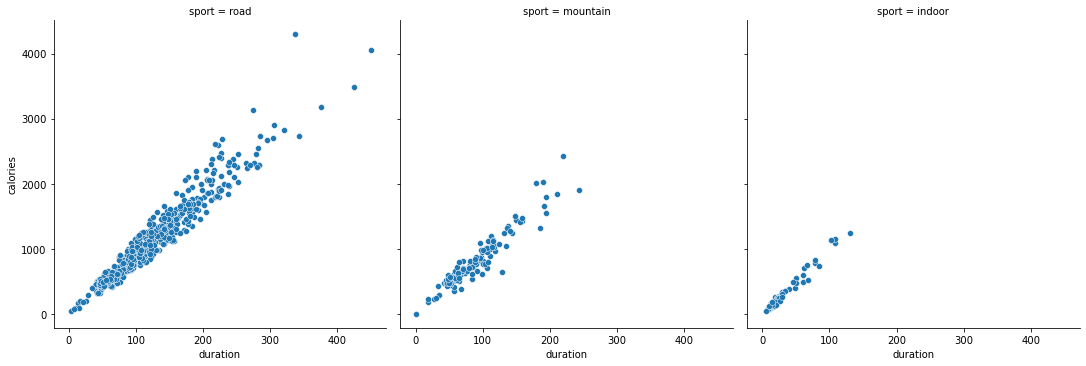

In [39]:
_ = sns.relplot(data=df, x='duration', y='calories', col='sport')

Using this interactive **Plotly** plot we can display the same content as our previous three plots in a single one, while also adding user interaction.We can easily appreciate the longest and hardest routes being always on a road bike. 

In [40]:
_ = df.iplot(kind='scatter', x='duration', y='calories', mode='markers', categories='sport')

Now we'll use a scatterplot of *duration* vs *climb* to visualize differentiating characteristics of the hardest rides. Notice how the 4 longest routes follow an almost perfectly linear trend, this is easily explained because most long-distance rides cannot be achieved unless the climb is restricted to a narrow margin of m/km. 

The two most extreme combined values were reached during a race and can thus be considered outliers quite safely.

In [41]:
px.scatter(df, x='duration', y='climb', color='calories')

Finally we'll use another interactive plot (**Ipywidgets**)  to display any combination of variables with the datapoints grouped by sport.

In [42]:
@interact(x=df.select_dtypes('number'), y=df.select_dtypes('number'), color=df.select_dtypes('object'))
def explore(x,y, color):
    sns.relplot(data=df, x=x, y=y, hue=color)

interactive(children=(Dropdown(description='x', options=('distance', 'duration', 'avg_speed', 'calories', 'hea…

## 4. Correlation and prediction models

We have two great predictor variables (*duration* and *distance*), so now it's just a matter of finding the best model to predict our caloric expenditure based on one or both of them.

## 4.1 Linear regression

Let's begin with simple linear regression. We are going to use both variables separately and evaluate both resulting models.

In [43]:
#Beginning with the first variable, duration.

x = df.duration
y = df.calories

stats.linregress(x,y)

LinregressResult(slope=9.086401164127427, intercept=13.378758843816286, rvalue=0.9700077722845797, pvalue=0.0, stderr=0.08060344043351227, intercept_stderr=10.139328526886292)

In [44]:
#Now that we have the slope and intercept we can define a simple predictor function.

def predict(x):
    return (9.086401164127427 * x) + 13.378758843816286

In [45]:
#Making a prediction with our function.

predict(60)

558.5628286914618

In [46]:
#Adding a constant to x.

X = sm.add_constant(x)

In [47]:
#Obtaining the new model.

model = sm.OLS(y, X)

In [48]:
#Training the model.

model = model.fit()

In [49]:
#Let's evaluate the model.

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               calories   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 1.271e+04
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        18:55:13   Log-Likelihood:                -5100.2
No. Observations:                 800   AIC:                         1.020e+04
Df Residuals:                     798   BIC:                         1.021e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.3788     10.139      1.319      0.187      -6.524      33.282
duration       9.0864      0.081    112.730      0.000       8.928       9.245
==============================================================================
Omnibus:                      269.505   Durbin-Watson:                   1.371
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2585.900
Skew:                           1.238   Prob(JB):                         0.00
Kurtosis:                      11.453   Cond. No.                         254.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='calories'>

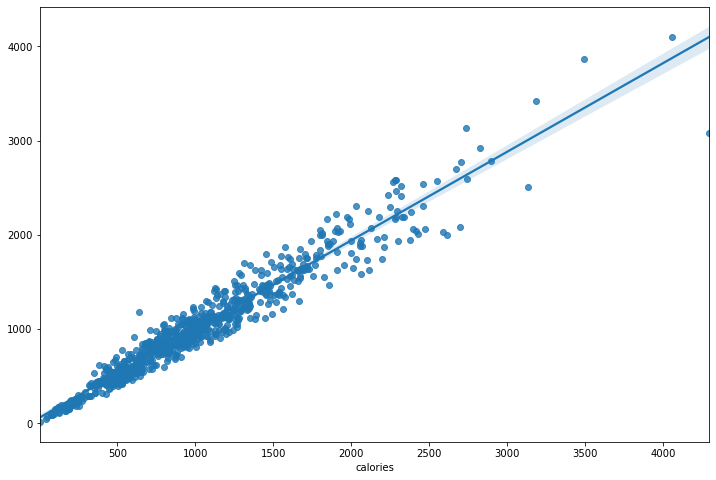

In [50]:
#Visualizing the correlation between our model prediction and the actual data.

sns.regplot(df['calories'], model.predict())

Now let's see how *distance* performs.

In [51]:
x = df.distance #Using distance as a predictor.
y = df.calories

stats.linregress(x,y)

LinregressResult(slope=20.427159403046563, intercept=85.09576663740756, rvalue=0.9402209692035035, pvalue=0.0, stderr=0.26192480617503294, intercept_stderr=13.749311076279662)

In [52]:
#Adding the constant, obtaining and fitting the model.

X = sm.add_constant(x) 
model2 = sm.OLS(y, X) 
model2 = model2.fit()

In [53]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               calories   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     6082.
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        18:55:13   Log-Likelihood:                -5370.0
No. Observations:                 800   AIC:                         1.074e+04
Df Residuals:                     798   BIC:                         1.075e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         85.0958     13.749      6.189      0.000      58.107     112.085
distance      20.4272      0.262     77.989      0.000      19.913      20.941
==============================================================================
Omnibus:                      303.318   Durbin-Watson:                   1.342
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1538.367
Skew:                           1.662   Prob(JB):                         0.00
Kurtosis:                       8.925   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

While the **R-squared** is still decent using only *distance*, it's nowhere near the value we got with *duration*.

Could we improve the model by combining both variables?

## 4.2 Multiple linear regression

Both variables gave good results, but we might be able to build a better model using them at the same time. For this purpose we are going to build a multiple linear regression model.

In [54]:
#I'm importing this library here because it overwrites a previous one.

import statsmodels.formula.api as sm 

In [55]:
model3 = sm.ols(formula='calories~duration+distance', data=df).fit()

In [56]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               calories   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     6437.
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        18:55:13   Log-Likelihood:                -5094.8
No. Observations:                 800   AIC:                         1.020e+04
Df Residuals:                     797   BIC:                         1.021e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.8161     10.079      1.371      0.171      -5.968      33.600
duration       8.1694      0.291     28.083      0.000       7.598       8.740
distance       2.2124      0.675      3.279      0.001       0.888       3.537
==============================================================================
Omnibus:                      268.538   Durbin-Watson:                   1.348
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2558.889
Skew:                           1.234   Prob(JB):                         0.00
Kurtosis:                      11.407   Cond. No.                         275.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 4.3 Can we generate a better model with *Sklearn*?

We will now take advantage of the great library that is **Sklearn** and use our best predictor variables (*duration, distance and climb*) to try and generate a more accurate model for our caloric expenditure.

In [126]:
#Creating a dataframe with our desired variables.

df_num = df[['distance', 'duration','climb','calories']]

In [127]:
#Defining our scaler, fitting and transforming our dataframe.

data_scaled = StandardScaler().fit_transform(df_num)

In [128]:
#Let's check the size of our Numpy array to verify that everything is as it should.

data_scaled.shape

(800, 4)

<AxesSubplot:ylabel='Density'>

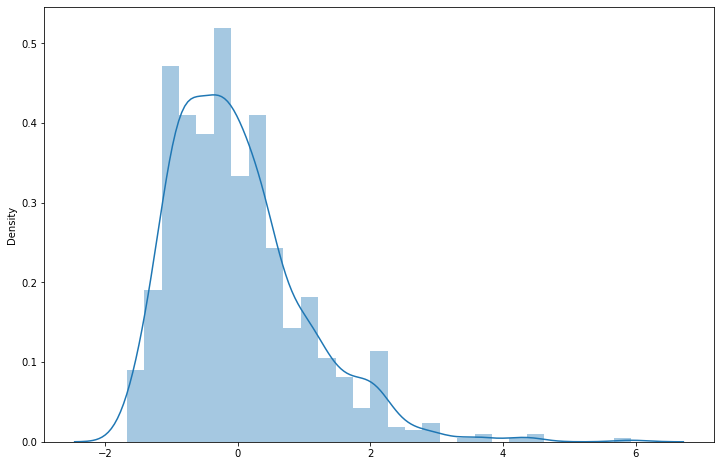

In [132]:
#Distribution plot of our variables.

sns.distplot(data_scaled[:,-4])

In [ ]:
#Defining our predictor and target variables.

X = data_scaled[:, 0:3]
y = data_scaled[:,-1]

In [ ]:
#Creating the model.

lr = LinearRegression()

In [ ]:
#Fitting the model.

lr.fit(X,y)

In [133]:
#Displaying the score.

lr.score(X,y)

0.9502486662922949

A score of 0.95 is **great**, but not an improvement over what we already had. I'll explain the possible reasons in the conclusions.

# 5. Hypothesis testing intro and data exploration

In this section I'm going to use **hypothesis testing** to verify a series of theories. Let's begin with the first one:


**Are heartrate values significantly higher when racing?**


To answer this very question I'm going to use a dataset exclusively made out of racing data, both mountain and road.

In [57]:
#Importing the csv with all racing data. Temps are omitted.

df_race = pd.read_csv('races.csv')

In [58]:
df_race.head()

,start,sport,distance,duration,avg_speed,calories,heartrate,climb,temp
0,2016-04-30 12:01:00,mountain,117.98,369,19.2,3006,159,1166,NaN
1,2019-04-14 08:07:00,road,91.07,217,25.2,2207,148,1791,NaN
2,2018-04-15 08:03:00,road,96.14,237,24.3,2282,147,1770,NaN
3,2018-06-17 08:01:00,road,138.79,320,26.0,2823,145,2142,NaN
4,2019-06-09 08:03:00,road,86.21,172,30.1,1756,151,1167,NaN


In [59]:
df_race.drop('temp', axis=1, inplace=True)

In [60]:
df_race.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   start      11 non-null     object 
 1   sport      11 non-null     object 
 2   distance   11 non-null     float64
 3   duration   11 non-null     int64  
 4   avg_speed  11 non-null     float64
 5   calories   11 non-null     int64  
 6   heartrate  11 non-null     int64  
 7   climb      11 non-null     int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 832.0+ bytes


In [61]:
#Let's compare the heartrate values of both the original df and the races df.

hr = df['heartrate']
hr.describe()

count    800.000000
mean     133.875000
std        7.815416
min       96.000000
25%      129.000000
50%      134.000000
75%      139.000000
max      160.000000
Name: heartrate, dtype: float64

In [62]:
hr_race = df_race['heartrate']
hr_race.describe()

count     11.000000
mean     150.272727
std        6.230424
min      142.000000
25%      146.000000
50%      150.000000
75%      154.500000
max      160.000000
Name: heartrate, dtype: float64

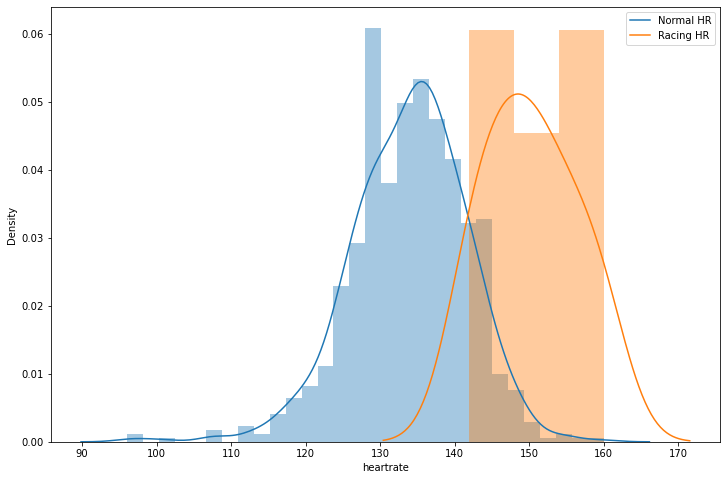

In [63]:
#Even though we have just a few values for heartrate in races, it's quite useful to compare them visually like so.

sns.distplot(hr)
sns.distplot(hr_race)
plt.legend(['Normal HR', 'Racing HR'])

These initial observations suggest that during races the heartbeats per minute are higher and with a lower standard deviation, meaning that those higher values seem to be more consistent than in normal rides.

To test this hypothesis we will resort to **null hypothesis testing**.

## 5.1 Performing hypothesis testing on HR values

In this case our **null hypothesis** is that the heartrate values aren't significantly different during racing.

In [64]:
alpha = 0.05 #Defining our alpha value.
r = sp.stats.ttest_ind(hr, hr_race)
print(r)
if (r.pvalue < alpha):
    print('The null hypothesis has been rejected.')
else:
    print("The null hypothesis hasn't been rejected.")

Ttest_indResult(statistic=-6.926964999582647, pvalue=8.772498457745025e-12)
The null hypothesis has been rejected.


As we can see from our extremely low **p-value** races have nothing in common with regular rides when it comes to heartrate. Which makes absolute sense.

But what about other variables like *calories* or *average speed*? 

## 5.2 Hypothesis testing on *calories*

In [65]:
#Like before, let's begin with some data exploration.

cal = df['calories']
cal.describe()

count     800.000000
mean     1005.875000
std       584.823373
min         2.000000
25%       592.500000
50%       904.500000
75%      1274.250000
max      4295.000000
Name: calories, dtype: float64

In [66]:
cal_race = df_race['calories']
cal_race.describe()

count      11.000000
mean     2482.000000
std       697.874201
min      1756.000000
25%      2105.500000
50%      2207.000000
75%      2648.500000
max      4295.000000
Name: calories, dtype: float64

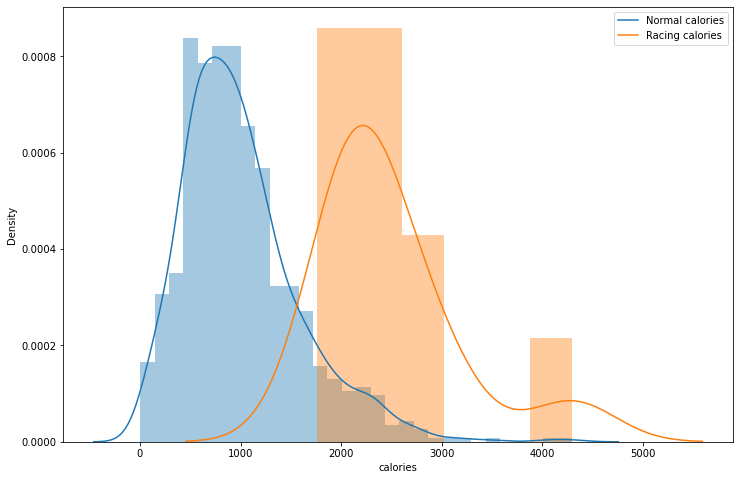

In [67]:
#Let's visualize that difference.

sns.distplot(cal)
sns.distplot(cal_race)
plt.legend(['Normal calories', 'Racing calories'])

Interestingly even with very few values for races (11) we can see how the caloric distribution on both datasets follows a very similar pattern, even down to tail asymmetry, shape and length. It's also obvious to see how they have very similar distributions *but* quite different values. 

Let's test our null hypothesis, in this case being that normal rides and races amount to the same caloric expenditure.

In [68]:
r = sp.stats.ttest_ind(cal, cal_race)
print(r)
if (r.pvalue < alpha):
    print('The null hypothesis has been rejected.')
else:
    print("The null hypothesis hasn't been rejected.")

Ttest_indResult(statistic=-8.29266771140842, pvalue=4.599847986625785e-16)
The null hypothesis has been rejected.


As in the previous case, the null hypothesis has been rejected.

## 5.2 Hypothesis testing on *average speed*

In this section we'll take a look at the average speed of our regular rides and races and determine if they are significantly different.

In [69]:
spd = df['avg_speed']
spd.describe()

count    800.000000
mean      24.776125
std        4.127325
min        8.100000
25%       22.700000
50%       25.400000
75%       27.000000
max       37.700000
Name: avg_speed, dtype: float64

In [70]:
spd_race = df_race['avg_speed']
spd_race.describe()

count    11.000000
mean     26.500000
std       4.002749
min      19.200000
25%      24.750000
50%      26.000000
75%      29.150000
max      33.300000
Name: avg_speed, dtype: float64

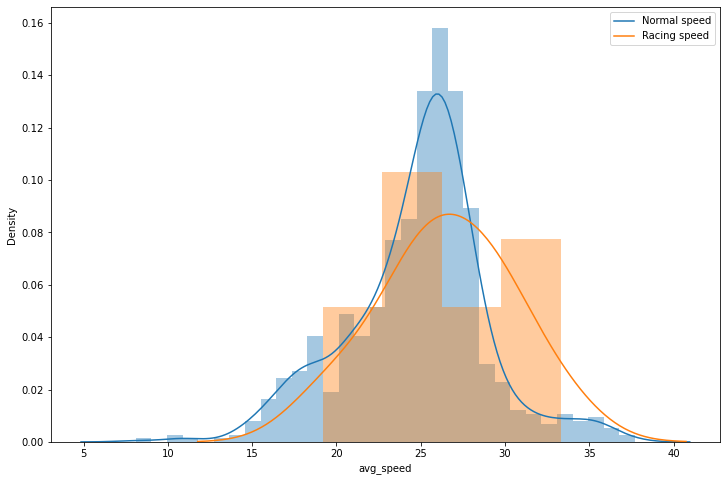

In [71]:
sns.distplot(spd)
sns.distplot(spd_race)
plt.legend(['Normal speed', 'Racing speed'])

In this case the difference isn't easily seen, since the center of both distributions seems to be quite close. This is probably due to a very low speed value during a mountain bike race. Let's test the null hypothesis and then repeat this exercise without taking into account that outlier.

In [72]:
r = sp.stats.ttest_ind(spd, spd_race)
print(r)
if (r.pvalue < alpha):
    print('The null hypothesis has been rejected.')
else:
    print("The null hypothesis hasn't been rejected.")

Ttest_indResult(statistic=-1.3763461303953282, pvalue=0.16909532271392388)
The null hypothesis hasn't been rejected.


Surprise! The null hypothesis **isn't** rejected, which means that the average speed isn't different in races (at least in any meaningful way).

So what would happen if we got rid of that outlier?

In [73]:
#Getting rid of the outlier.

spd_race_mod = spd_race[1:]

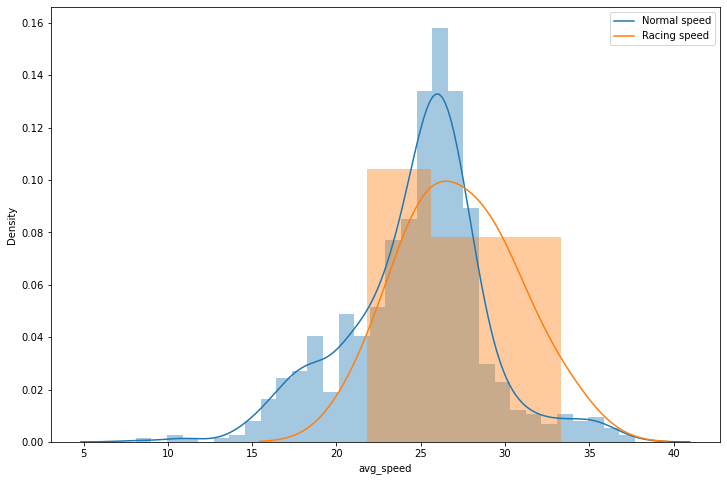

In [74]:
#Let's see how the distribution looks now:

sns.distplot(spd)
sns.distplot(spd_race_mod)
plt.legend(['Normal speed', 'Racing speed'])

The distribution has changed, but just *barely so*. Will it be enough to reject our null hypothesis?

In [75]:
r = sp.stats.ttest_ind(spd, spd_race_mod) #Loading new race data without the outlier.
print(r)
if (r.pvalue < alpha):
    print('The null hypothesis has been rejected.')
else:
    print("The null hypothesis hasn't been rejected.")

Ttest_indResult(statistic=-1.8719904396914016, pvalue=0.061568967122791925)
The null hypothesis hasn't been rejected.


So even if we get rid of the outlier the null hypothesis prevails, meaning that the average speed in a race is just like that of a normal ride **but** the heartrate and caloric expenditure are way higher.

How can that be? 

My theory is that the higher effort shown by elevated heartrate/calories isn't reflected in the average speed because that extra energy is working to elevate (pun intended) the values of a different variable: **climb**.

## 5.3 Hypothesis testing on *climb*

Let's verify our theory.

In [76]:
climb = df['climb']
climb.describe()

count     800.000000
mean      455.420000
std       392.482987
min         0.000000
25%       194.000000
50%       335.500000
75%       591.500000
max      2602.000000
Name: climb, dtype: float64

In [77]:
climb_race = df_race['climb']
climb_race.describe()

count      11.000000
mean     1588.636364
std       478.636662
min      1102.000000
25%      1183.500000
50%      1640.000000
75%      1780.500000
max      2602.000000
Name: climb, dtype: float64

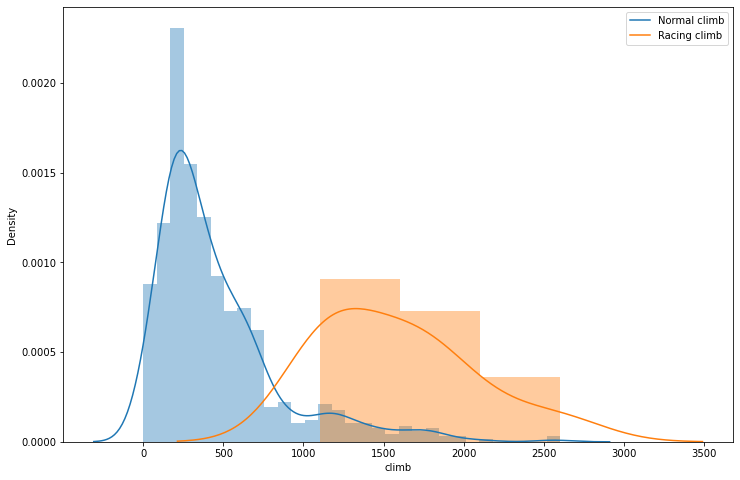

In [78]:
sns.distplot(climb)
sns.distplot(climb_race)
plt.legend(['Normal climb', 'Racing climb'])

As the previous plot shows, during a typical race the elevation is *way* higher than in most regular rides. But are those values really that different? Let's find out.

In [138]:
r = sp.stats.ttest_ind(climb, climb_race) #Loading new race data without the outlier.
print(r)
if (r.pvalue < alpha):
    print('The null hypothesis has been rejected.')
else:
    print("The null hypothesis hasn't been rejected.")

Ttest_indResult(statistic=-9.482418300639807, pvalue=2.6842755192854845e-20)
The null hypothesis has been rejected.


The extremely low **p-value** firrmly rejects the nul hypothesis, which means that climb data from regular rides and races has nothing in common. 

<br>This validates our theory that the extra energy spent during a race is usually transformed into higher climbs instead of a higher average speed.

# 7. Conclusions

While we were able to fully answer all our initial questions, several issues have arisen after dealing with this data.


For example, before I started this project I expected *calories* to depend on more variables than simply *distance* and *duration*, and the extreme linearity of the three wasn't something I expected. Before taking a look at the data I believed that heartrate would be very influential, but it hasn't been. 


It's also quite interesting how dissimilar are races to regular bike rides, but that was something I already expected.

This kind of things happen because we tend to make assumptions and take some facts for granted, and we would keep believing them unless we can get our hands on the right data to disprove them with empirical facts.

<div align="right">Ironhack DA PT 2021</div>
    
<div align="right">Xavier Esteban</div>